In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from forecasting.dataset import import_data, preprocess_data, make_train_test_split, split_into_x_y
from forecasting.features import reformat_columns, make_features, make_col_transformer
from forecasting.utils import train_config

## Importing data

In [2]:
df_raw = import_data(train_config['input_data_path'])
df = reformat_columns(df_raw)
df = make_features(df)
df_processed = preprocess_data(df)
X, y = split_into_x_y(df_processed)

X_train, X_test, y_train, y_test = make_train_test_split(X, y)

## Exploratory data analysis

The data contains traffic volume for specific time (at hourly intervals between years 2012 - 2018). I perform data analysis to explore:

 - seasonality of the data (daily, annualy)
 - importnace of additional factors like weather

In [3]:
from forecasting.plots import plot_traffic_histogram, plot_aggregated_traffic, plot_boxplot

#### histogram
 - the histogram reveals non-normal distribution of the traffic data, with 3 distinct peaks
 - there is particularly high frequency of small traffic volume, ranging between from approx. 250 to 450

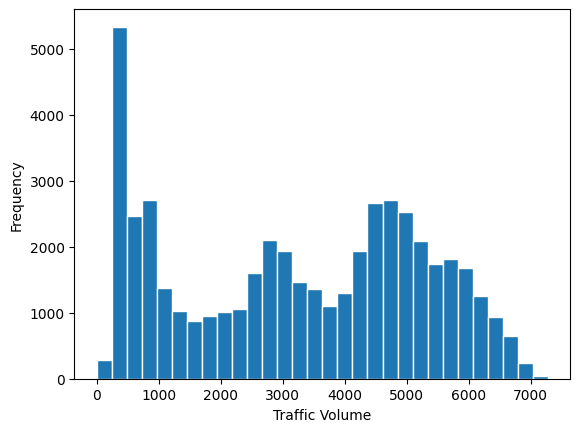

In [4]:
plot_traffic_histogram(df)

#### seasonality

The data shows very strong seasonal patters:
 - daily seasonality is particularly strong, with distinct peaks during morning and afternoon rush hours, followed by a significant drop during night time
 - monthly seasonality is less pronounced, but the winter months (January, November, and December) generally show reduced activity
 - weekly patterns also influence the traffic, with lower volumes observed during the weekends, especially on Sundays

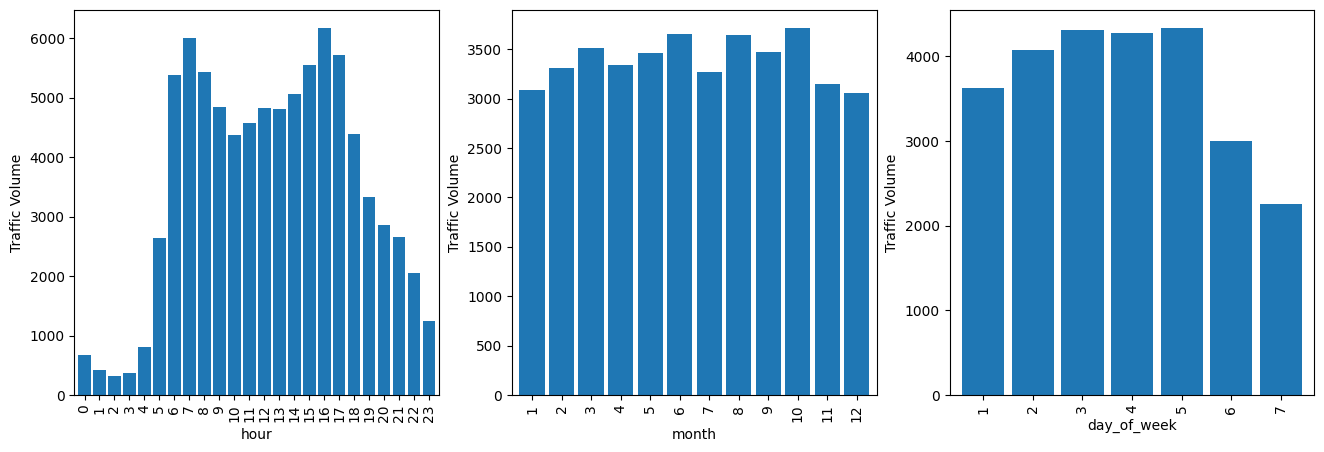

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

plot_aggregated_traffic(df, 'hour', ax=axes[0])
plot_aggregated_traffic(df, 'month', ax=axes[1])
plot_aggregated_traffic(df, 'day_of_week', ax=axes[2])

#### weather

The median traffic volume varies depending on weather conditions. For example, traffic levels tend to be lower during foggy conditions. <br>
However, it is important to consider that weather conditions may correlate with specific times of the day. For instance, fog frequently occurs early in the morning. Given this, analyses that focus solely on univariate correlations with traffic volume could potentially be misleading. <br><br>
In the bottom chart, I present an analysis supporting the hypothesis that fog primarily occurs during the early morning or at night. This suggests that time of day, rather than fog, is more likely to be the primary factor influencing lower traffic volumes.

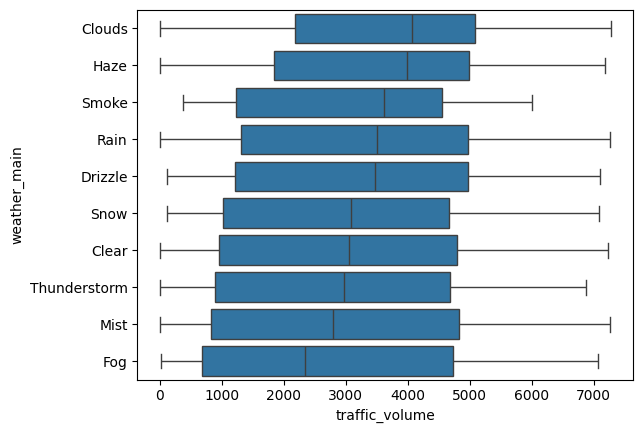

In [6]:
plot_boxplot(df, 'weather_main', top=10)

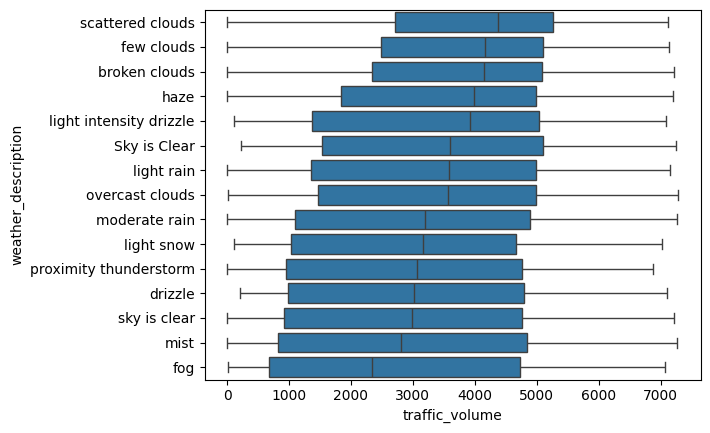

In [7]:
plot_boxplot(df, 'weather_description', top=15)

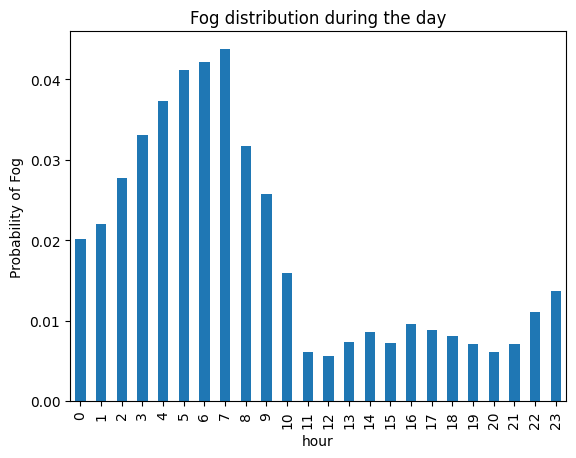

In [8]:
# plot average fog occurence for different time of the day
df.weather_main.eq('Fog').groupby(df.hour).mean().plot.bar()
plt.ylabel('Probability of Fog')
plt.title('Fog distribution during the day');

## Modelling

In [10]:
from forecasting.modelling.model_selection import make_random_search, baseline_models_estimation

#### Scoring function
I choose mean squared error as a scoring function for several reasons:
 - it is commonly used error metric for a regression problem 
 - it penalizes higher deviations to a bigger extend (comparing to MAE for example). This is in my opinion desired in the traffic volume prediction as big deviations 
            from actuals may lead to negative consequences like traffic congestion or not optimal use of resources.
 - we don't observe any significant outliers in the target variable. The presence of outliers can significantly impact the model parameters since errors are squared.
            As a result this could introduce a bias in the model.

#### Baseline models
Estimating baseline models with default parameters. <br> Based on the result I get the idea of which algorithm is promising 
and worth further exploration in hyperparameters tuning

In [11]:
baseline_results = baseline_models_estimation(X_train, y_train)

Running pipeline for LinearRegression
Running pipeline for Ridge
Running pipeline for ElasticNet
Running pipeline for RandomForestRegressor


#### Performance of baseline models
Random forest regressor clearly outperforms other algorithms - the mean squared error is significantly lower <br>
In the next step, its performance can be further improved by utilizing hyperparameters tuning technique

<BarContainer object of 4 artists>

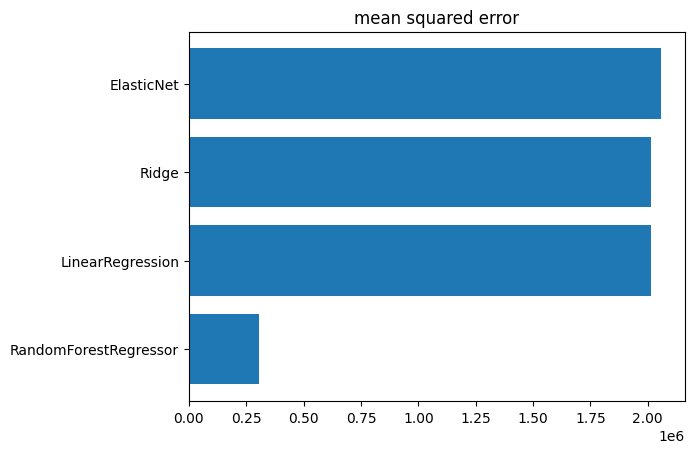

In [12]:
plt.title('mean squared error')
plt.barh(baseline_results.keys(), -np.array(list(baseline_results.values())))

#### Hyperparameters optimization using random search
I select two best performing baseline models and use them in random search to tune hyperparameters. <br>
Finally, the best model from the random search will be used

In [13]:
top_2_models = list(baseline_results.keys())[:2]
results_rs = make_random_search(top_2_models, X_train, y_train)

Running random search for RandomForestRegressor
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Running random search for LinearRegression
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\krzysztof_rozycki\OneDrive - EPAM\projects\learning\forecasting\venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=15. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Random forest model after hyperparameters optimization significantly outperforms linear regression model, therefore will be used as a final model

Text(0.5, 1.0, 'mean squared error')

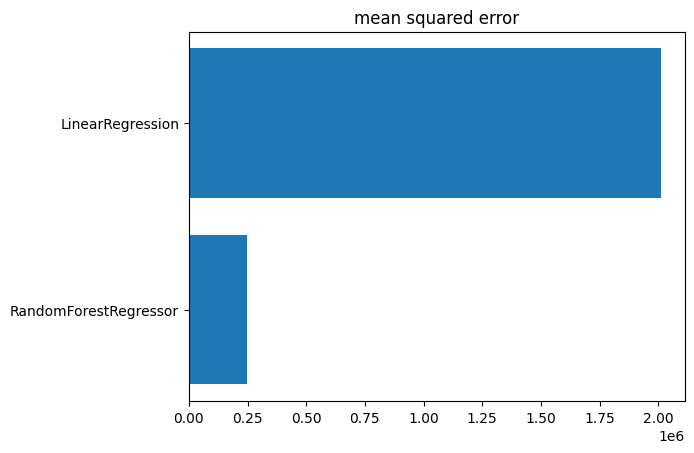

In [16]:
models = results_rs.keys()
results = [-score.best_score_ for score in results_rs.values()]
plt.barh(models, results)
plt.title('mean squared error')

#### Prediction on test data

In [17]:
# make prediction on test data with the model
final_model = results_rs['RandomForestRegressor'].best_estimator_
y_test_pred = final_model.predict(X_test)

The visual analysis shows that the model prediction is close to the actual values in out-of-sample data. <br>
The series is mainly driven by the seasonality patterns, which the model was ably to reflect in the forecast

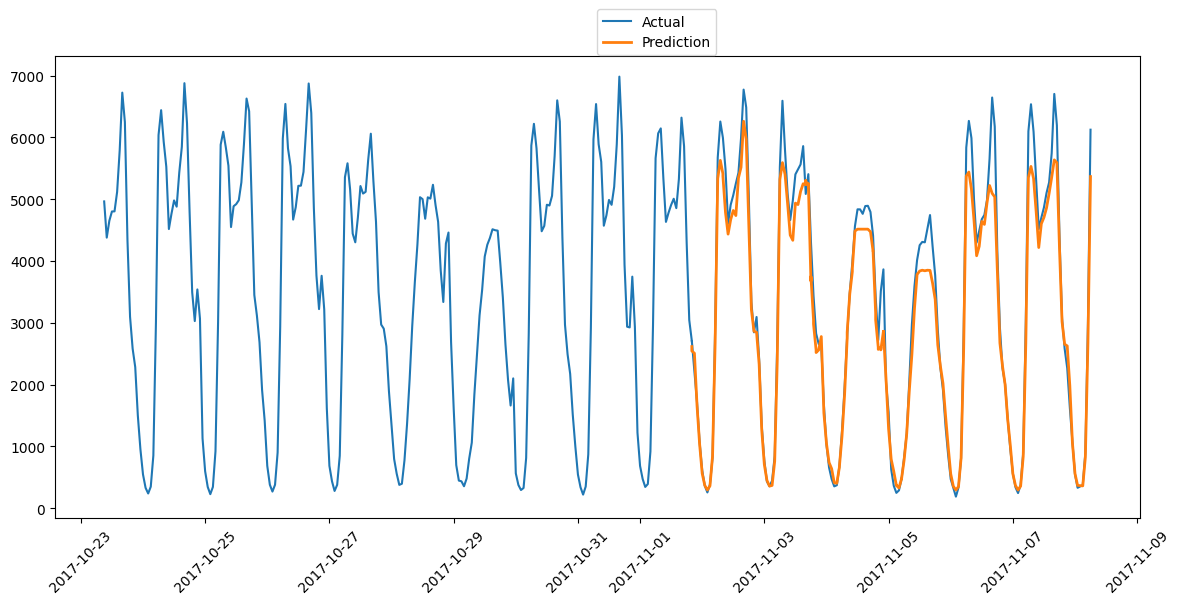

In [18]:
# plot actuals vs predicted values (a sample only for better readability)
n_actuals = 300
n_prediction = 200

y_test_pred_series = pd.Series(y_test_pred, index=X_test.date_time)
y_test_series = pd.Series(y_test, index=X_test.date_time)
y_train_series = pd.Series(y_train, index=X_train.date_time)

plt.figure(figsize=(14, 6))
plt.plot(y_train_series.iloc[-n_actuals:], c='tab:blue', label='Actual')
plt.plot(y_test_series.iloc[:n_prediction], c='tab:blue')
plt.plot(y_test_pred_series.iloc[:n_prediction], c='tab:orange', linestyle='-', linewidth=2, label='Prediction')
plt.legend(loc=[.5, 1.001])
plt.xticks(rotation=45);

#### Features importance
The Random Forest regressor provides a useful feature importances property, which helps in identifying which variables are most influential in making predictions. 
 - The analysis reveals that the primary drivers of the prediction are daily seasonality ('hour') and day_of_week. 
 - Among the weather variables, temperature has some influence on the forecast, although its relative importance is modest.

<BarContainer object of 23 artists>

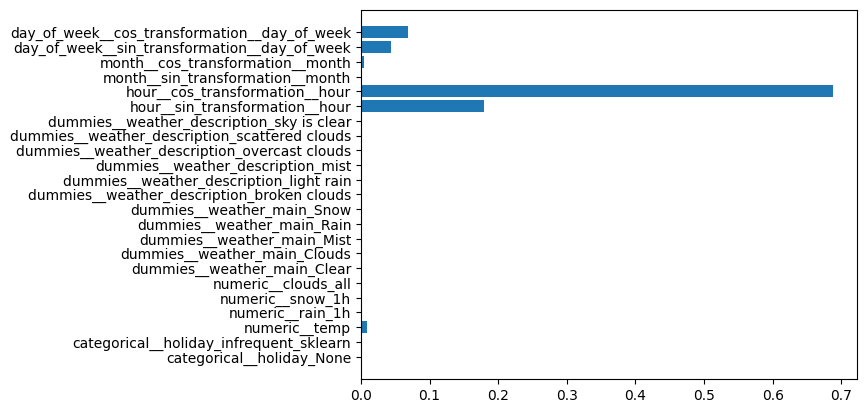

In [19]:
features_names = final_model.steps[0][1].get_feature_names_out()
feature_importances = final_model.steps[1][1].feature_importances_

plt.barh(features_names, feature_importances)

In [20]:
# save final model
from forecasting.utils import save_model
save_model(final_model, '../models/model_jupyter.pkl')